# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    - The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew. 
    - The agreed criteria for the model performance is 97% accuracy.

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Cherry Leave Images distribution plot in train, validation, and test dataset.
* Data augmentation.
* Class indices to change prediction inference in labels.
* ML model creation and training.
* Save trained model.
* Plot model earning curve for performance.
* Model evaluation on pickle file.
* Tuning model hyperparameters for achieving agreed accuracy. 
* Saved improved model and training metrics
* Validation model on the random image file prediction.

## Additional Comments

---

## Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\zoe\\ML-Mildew-Detector-\\jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\zoe\\ML-Mildew-Detector-'

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set input directories for train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1-mildew'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Class Labels are', labels)

Class Labels are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
## Import image shape embedding saved at repo
version = 'v1-mildew'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Plot number of images in train, test and validation dataset

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




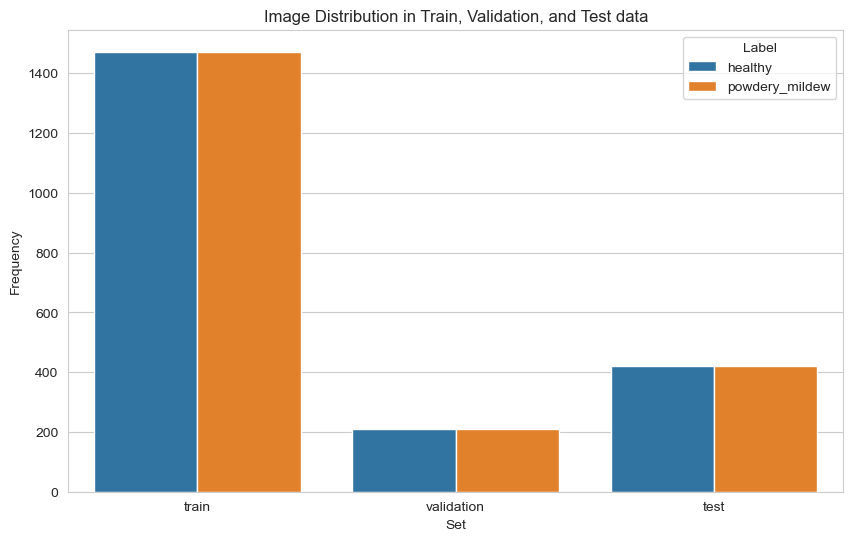

In [9]:
import glob

data_dirs = ['train', 'validation', 'test']

df_freq = pd.DataFrame([])

for folder in data_dirs:
    for label in os.listdir(os.path.join(my_data_dir, folder)):
        image_count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = df_freq.append(pd.Series(data={'Set': folder, 'Label': label, 'Frequency': image_count}), ignore_index=True)
        print(f"* {folder} - {label}: {image_count} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Train, Validation, and Test data")
plt.xlabel("Set")
plt.ylabel("Frequency")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

----

## Image data augmentation

### Import and Initialize ImageDataGenerator

Generate augmented images to produce variations of the original images for training the deep learning model, thereby enhancing its ability to handle a wider range of real-world scenarios.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [11]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented image in training set

(20, 256, 256, 3)


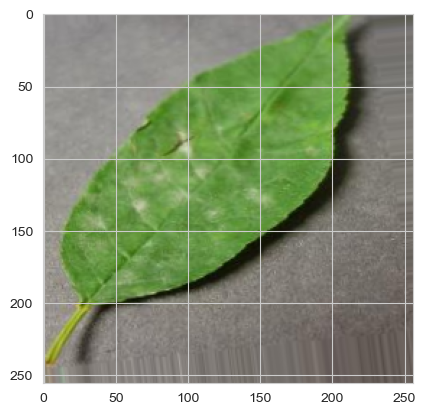

(20, 256, 256, 3)


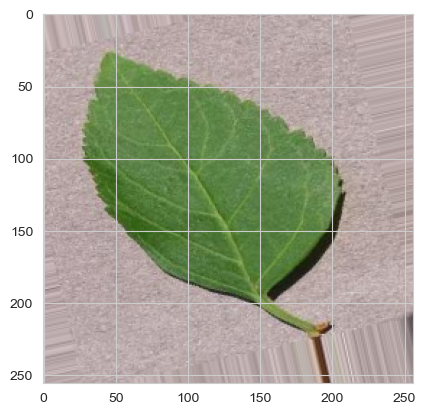

(20, 256, 256, 3)


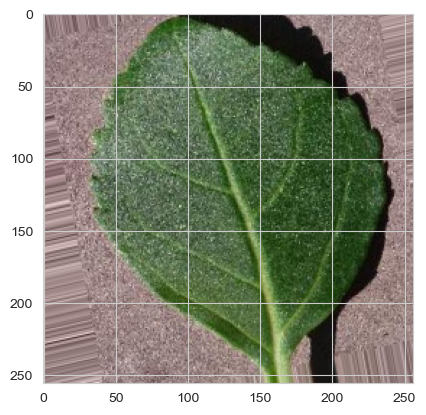

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Plot augmented images in validation and test sets

(20, 256, 256, 3)


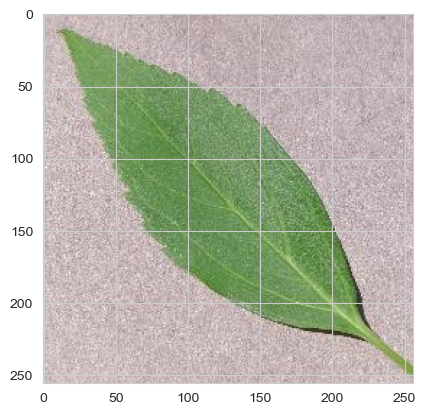

(20, 256, 256, 3)


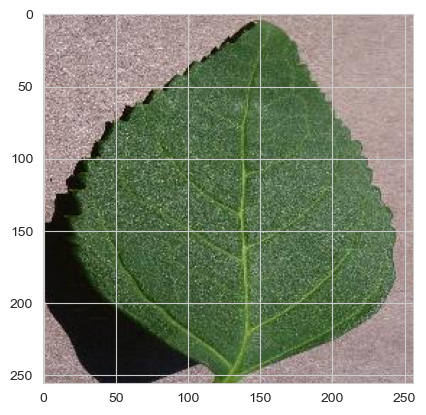

(20, 256, 256, 3)


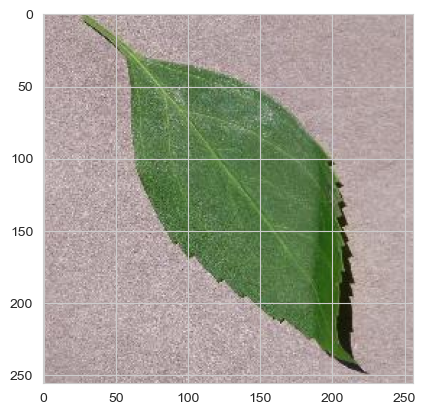

In [15]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


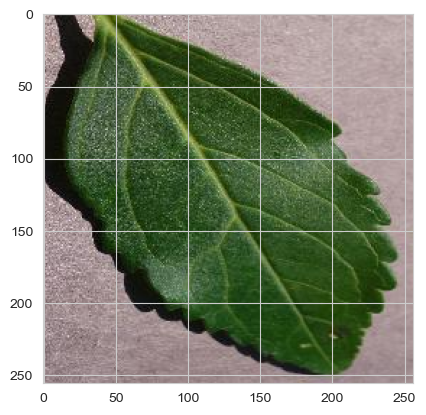

(20, 256, 256, 3)


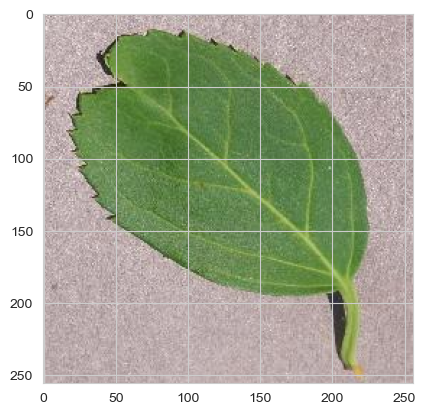

(20, 256, 256, 3)


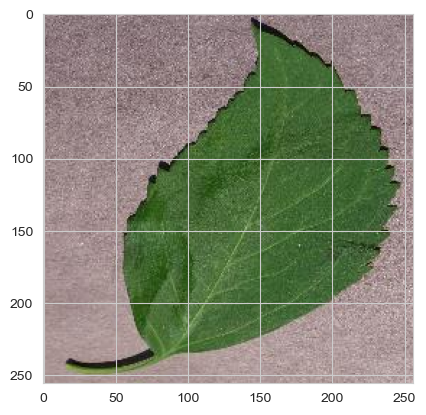

In [16]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [17]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1-mildew/class_indices.pkl']

---

## Model Creation

### Set up ML Model layout

* Import model package and create model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

def create_mildew_tf_model():
    model = Sequential()

    # Add Convolutional and Pooling Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # Add Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization for better training stability
    model.add(Dropout(0.5))  # Dropout for regularization
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* Model Summary

In [25]:
create_mildew_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

* Set Early Stopping to model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit ML model for model training

In [26]:
model = create_mildew_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 130s 881ms/step - loss: 0.1000 - accuracy: 0.9682 - val_loss: 8.5198 - val_accuracy: 0.5000
Epoch 2/25
147/147 [==============================] - 109s 741ms/step - loss: 0.0636 - accuracy: 0.9850 - val_loss: 0.0342 - val_accuracy: 0.9929
Epoch 3/25
147/147 [==============================] - 110s 748ms/step - loss: 0.0504 - accuracy: 0.9867 - val_loss: 0.0222 - val_accuracy: 0.9929
Epoch 4/25
147/147 [==============================] - 111s 756ms/step - loss: 0.0434 - accuracy: 0.9891 - val_loss: 7.4032 - val_accuracy: 0.5000
Epoch 5/25
147/147 [==============================] - 112s 761ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.1312 - val_accuracy: 0.9548
Epoch 6/25
147/147 [==============================] - 112s 761ms/step - loss: 0.0371 - accuracy: 0.9908 - val_loss: 0.2197 - val_accuracy: 0.9190


## Model Performance Evaluation

#### Plot model learning curve

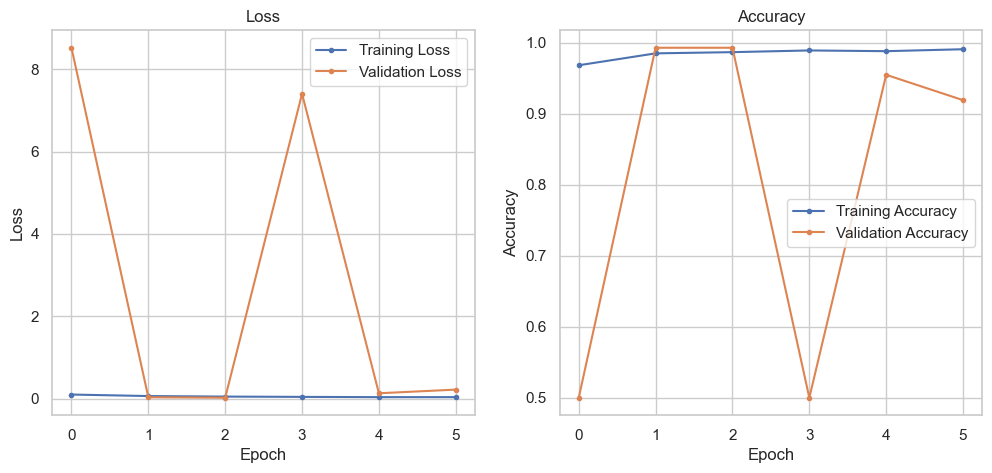

In [29]:
losses = pd.DataFrame(model.history.history)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set the style
sns.set(style="whitegrid")

# Loss plot
losses[['loss', 'val_loss']].plot(style='.-', ax=ax1)
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(["Training Loss", "Validation Loss"])
ax1.grid(True)

# Accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', ax=ax2)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"])
ax2.grid(True)

# Save the plots
plt.savefig(f'{file_path}/model_training_metrics.png', bbox_inches='tight', dpi=150)

# Show the combined plot
plt.show()

#### Model Evaluation

Evaluate model on test set and save evaluation pickle

In [32]:
#Load saved model
from keras.models import load_model
model = load_model('outputs/v1-mildew/mildew_detecting_model.h5')

#Fit the model to test set
mildew_eva = model.evaluate(test_set)

joblib.dump(value=mildew_eva,
            filename=f"outputs/v1-mildew/mildew_model_evaluation.pkl")

43/43 [==============================] - 7s 164ms/step - loss: 0.2493 - accuracy: 0.9017


['outputs/v1-mildew/mildew_model_evaluation.pkl']

### Model Optimization for better validation loss learning and improving predict accuracy

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_mildew_tf_model():
    model = Sequential()

    # Add Convolutional and Pooling Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Add Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with adjusted learning rate and metrics
    optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Fit the model with modified batch size and epochs
model = create_mildew_tf_model()
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=100,  # Adjust the number of epochs
    batch_size=32,  # Adjust the batch size
    callbacks=[early_stopping, reduce_lr]  # Apply early stopping and learning rate reduction
)




Epoch 1/100
148/148 [==============================] - 109s 732ms/step - loss: 0.1058 - accuracy: 0.9633 - val_loss: 4.3038 - val_accuracy: 0.5143
Epoch 2/100
148/148 [==============================] - 111s 749ms/step - loss: 0.0669 - accuracy: 0.9823 - val_loss: 3.8262 - val_accuracy: 0.5452
Epoch 3/100
148/148 [==============================] - 115s 777ms/step - loss: 0.0605 - accuracy: 0.9820 - val_loss: 1.2843 - val_accuracy: 0.5452
Epoch 4/100
148/148 [==============================] - 114s 766ms/step - loss: 0.0481 - accuracy: 0.9878 - val_loss: 0.1957 - val_accuracy: 0.9357
Epoch 5/100
148/148 [==============================] - 110s 740ms/step - loss: 0.0277 - accuracy: 0.9922 - val_loss: 1.9411 - val_accuracy: 0.6976
Epoch 6/100
148/148 [==============================] - 122s 821ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 2.6949 - val_accuracy: 0.5000
Epoch 7/100
148/148 [==============================] - 114s 765ms/step - loss: 0.0336 - accuracy: 0.9908 - val_loss: 0

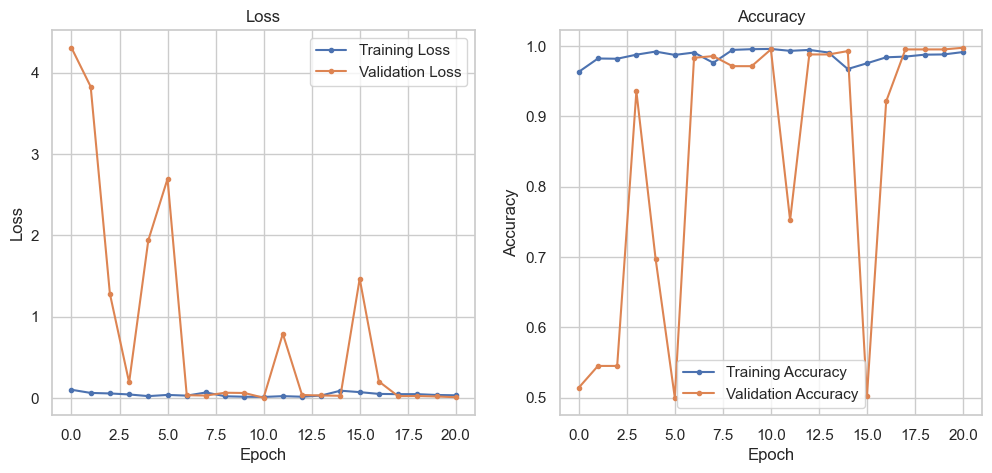

In [35]:
#plot model learning curve
losses = pd.DataFrame(model.history.history)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set the style
sns.set(style="whitegrid")

# Loss plot
losses[['loss', 'val_loss']].plot(style='.-', ax=ax1)
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(["Training Loss", "Validation Loss"])
ax1.grid(True)

# Accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', ax=ax2)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"])
ax2.grid(True)

# Save the plots
plt.savefig(f'{file_path}/model_training_metrics1.png', bbox_inches='tight', dpi=150)

# Show the combined plot
plt.show()

In [36]:
#model evaluation

#Load saved model
from keras.models import load_model
model = load_model('outputs/v1-mildew/mildew_detecting_model1.h5')

#Fit the model to test set
mildew_eva = model.evaluate(test_set)

joblib.dump(value=mildew_eva,
            filename=f"outputs/v1-mildew/mildew_model_evaluation1.pkl")

43/43 [==============================] - 8s 184ms/step - loss: 0.0162 - accuracy: 0.9953


['outputs/v1-mildew/mildew_model_evaluation1.pkl']

### Tuning ML Model for more stabilized validation loss and accuracy

In [93]:
from tensorflow.keras.optimizers import RMSprop
def create_mildew_tf_model():
    model = Sequential()

    # Add Convolutional and Pooling Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Add Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with adjusted learning rate and metrics
    optimizer = 'RMSprop' #change optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Fit the model with modified batch size and epochs
model = create_mildew_tf_model()
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=50,  
    batch_size=25,  # Adjust the batch size
    callbacks=[early_stopping, reduce_lr]  # Apply early stopping and learning rate reduction
)


Epoch 1/50
148/148 [==============================] - 111s 743ms/step - loss: 0.0949 - accuracy: 0.9708 - val_loss: 8.4484 - val_accuracy: 0.5000
Epoch 2/50
148/148 [==============================] - 110s 745ms/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 1.1113 - val_accuracy: 0.6833
Epoch 3/50
148/148 [==============================] - 111s 747ms/step - loss: 0.0391 - accuracy: 0.9864 - val_loss: 0.0225 - val_accuracy: 0.9929
Epoch 4/50
148/148 [==============================] - 111s 749ms/step - loss: 0.0360 - accuracy: 0.9905 - val_loss: 0.3377 - val_accuracy: 0.8833
Epoch 5/50
148/148 [==============================] - 110s 745ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 5.0221 - val_accuracy: 0.5000
Epoch 6/50
148/148 [==============================] - 324s 2s/step - loss: 0.0305 - accuracy: 0.9915 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/50
148/148 [==============================] - 105s 707ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0102 - va

Save the tuned model

In [94]:
# Save the model and training history for future reference
model.save('outputs/v1-mildew/mildew_detecting_model2.h5')

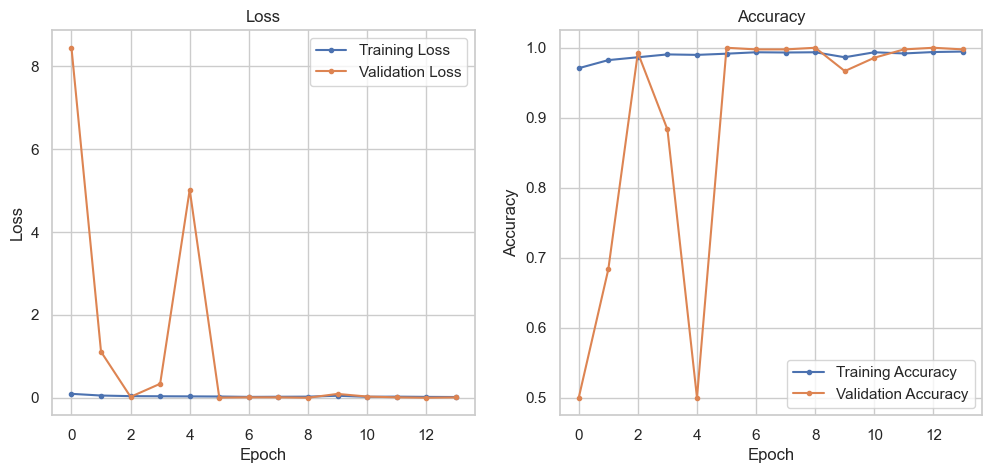

In [95]:
#plot model learning curve
losses = pd.DataFrame(model.history.history)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Set the style
sns.set(style="whitegrid")

# Loss plot
losses[['loss', 'val_loss']].plot(style='.-', ax=ax1)
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(["Training Loss", "Validation Loss"])
ax1.grid(True)

# Accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', ax=ax2)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"])
ax2.grid(True)

# Save the plots
plt.savefig(f'{file_path}/model_training_metrics2.png', bbox_inches='tight', dpi=150)

# Show the combined plot
plt.show()

In [96]:
#model evaluation

#Load saved model
from keras.models import load_model
model = load_model('outputs/v1-mildew/mildew_detecting_model2.h5')

#Fit the model to test set
mildew_eva = model.evaluate(test_set)

joblib.dump(value=mildew_eva,
            filename=f"outputs/v1-mildew/mildew_model_evaluation2.pkl")

43/43 [==============================] - 6s 139ms/step - loss: 0.0020 - accuracy: 0.9988


['outputs/v1-mildew/mildew_model_evaluation2.pkl']

### New/real life data prediction

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


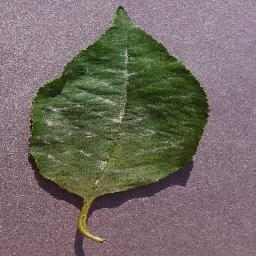

In [104]:
from tensorflow.keras.preprocessing import image

pointer = 15
label = labels[1]  # select healthy [0] or powdery_mildew contained [1]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Predict the new/live data to its class with a probability

In [105]:
#convert image to array

test_image = image.img_to_array(pil_image)
test_image = np.expand_dims(test_image, axis=0)/255
print(test_image.shape)

#fit the trained model for class probabilities
pred_prob = model.predict(test_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_prob > 0.97]

if pred_class == target_map[0]:
    pred_prob = 1 - pred_prob

print(pred_prob)
print(pred_class)

(1, 256, 256, 3)
0.99997455
powdery_mildew


## Push files to Repo

In [46]:
with open('.gitignore', 'r') as file:
    contents = file.read()
    print(contents)

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/mildew_dataset/cherry-leaves/test
inputs/mildew_dataset/cherry-leaves/train


Install Git LFS for large file storage

In [120]:
!git lfs install

Updated Git hooks.
Git LFS initialized.


Track files with the .h5 extension using Git LFS

In [4]:
!git lfs migrate import --include="outputs/v1-mildew/mildew_detecting_model2.h5"

^C


In [ ]:
!git lfs ls-files

In [122]:
!git lfs track "*.h5"

"*.h5" already supported


In [126]:
!git add .gitattributes
!git commit -m "Add Git LFS configuration"
!git push

On branch main
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   outputs/v1-mildew/mildew_detecting_model.h5
	modified:   outputs/v1-mildew/mildew_detecting_model1.h5
	modified:   outputs/v1-mildew/mildew_detecting_model2.h5

no changes added to commit (use "git add" and/or "git commit -a")


remote: warning: File outputs/v1-mildew/mildew_detecting_model2.h5 is 56.74 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: error: Trace: d9e034178f7225c6988f3ac4605643bc1e35012e3868ba7b21965911cb8bba62        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File outputs/v1-mildew/mildew_detecting_model.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: File outputs/v1-mildew/mildew_detecting_model1.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/yuyizhong/ML-Mildew-Detector-.git
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/yuyizhong/ML-Mildew-Detector-.git'


In [10]:
!git add ../outputs/v1-mildew/*.h5
!git commit -m"save work in notebook"

[main 44f7168] save work in notebook
 3 files changed, 0 insertions(+), 0 deletions(-)
 delete mode 100644 outputs/v1-mildew/mildew_detecting_model.h5
 delete mode 100644 outputs/v1-mildew/mildew_detecting_model1.h5


In [11]:
!git rm ../outputs/v1-mildew/*.h5
!git lfs track "../outputs/v1-mildew/*.h5"
!git add .gitattributes
!git commit -m "Move file to Git LFS"

rm 'outputs/v1-mildew/mildew_detecting_model2.h5'
Tracking "../outputs/v1-mildew/*.h5"
[main 2f614fc] Move file to Git LFS
 2 files changed, 1 insertion(+), 3 deletions(-)
 create mode 100644 jupyter_notebooks/.gitattributes
 delete mode 100644 outputs/v1-mildew/mildew_detecting_model2.h5


In [13]:
! git push

Uploading LFS objects: 100% (1/1), 60 MB | 0 B/s, done.


remote: warning: File outputs/v1-mildew/mildew_detecting_model2.h5 is 56.74 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: error: Trace: 93336b7ad607d071cb73d28a1056302d4018c820f6ff09dbeced77bc50c9a922        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File outputs/v1-mildew/mildew_detecting_model.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: File outputs/v1-mildew/mildew_detecting_model1.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/yuyizhong/ML-Mildew-Detector-.git
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/yuyizhong/ML-Mildew-Detector-.git'


In [8]:
! git commit -m"add new slots"

On branch main
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../.gitattributes
	deleted:    Notebook.ipynb
	deleted:    ../outputs/v1-mildew/mildew_detecting_model.h5
	deleted:    ../outputs/v1-mildew/mildew_detecting_model1.h5
	modified:   ../outputs/v1-mildew/mildew_detecting_model2.h5

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git rm path/to/your/largefile.h5

In [9]:
! git push

remote: warning: File outputs/v1-mildew/mildew_detecting_model2.h5 is 56.74 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: error: Trace: 37c5c2efecaebc087b6ee98d44d12f1713c41b4f62f42db16d43dd51caf9cfd2        
remote: error: See https://gh.io/lfs for more information.        
remote: error: File outputs/v1-mildew/mildew_detecting_model.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: File outputs/v1-mildew/mildew_detecting_model1.h5 is 169.47 MB; this exceeds GitHub's file size limit of 100.00 MB        
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/yuyizhong/ML-Mildew-Detector-.git
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://github.com/yuyizhong/ML-Mildew-Detector-.git'
